In [ ]:
import torch
from torch import nn

import math

import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [ ]:
torch.manual_seed(111)

In [ ]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# prepare train data

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

In [ ]:
train_set = torchvision.datasets.FashionMNIST(
    root=".", train=True, download=True, transform=transform
)

100%|██████████| 26421880/26421880 [00:02<00:00, 12434078.39it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 208899.84it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3951215.16it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6109868.98it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [ ]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

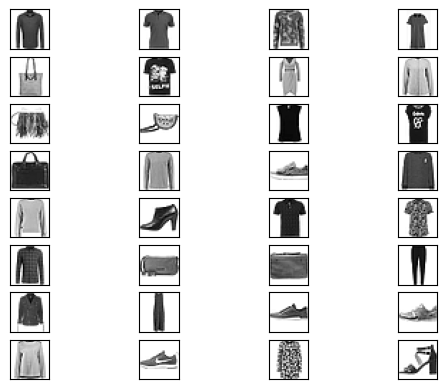

In [ ]:
real_samples, fashion_mnist_labels = next(iter(train_loader))
for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

# Implementing the Discriminator and the Generator

## **1. Discriminator**

In [ ]:
# class Discriminator(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.model = nn.Sequential(
#             nn.Linear(784, 1024),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(1024, 512),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(512, 256),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(256, 1),
#             nn.Sigmoid(),
#         )

#     def forward(self, x):
#         x = x.view(x.size(0), 784)
#         output = self.model(x)
#         return output

In [ ]:
#homework

import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        output = self.model(x)
        return output


In [ ]:
discriminator = Discriminator().to(device=device)

## **2. Generator**

In [ ]:
# class Generator(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.model = nn.Sequential(
#             nn.Linear(100, 256),
#             nn.ReLU(),
#             nn.Linear(256, 512),
#             nn.ReLU(),
#             nn.Linear(512, 1024),
#             nn.ReLU(),
#             nn.Linear(1024, 784),
#             nn.Tanh(),
#         )

#     def forward(self, x):
#         output = self.model(x)
#         output = output.view(x.size(0), 1, 28, 28)
#         return output

# generator = Generator().to(device=device)

In [ ]:
#Homework
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 128),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Linear(128, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Linear(256, 512),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.Linear(512, 28 * 28 * 1),
            nn.Tanh()
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output


# Training the Models




In [ ]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [ ]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.13079094886779785
Epoch: 0 Loss G.: 2.419593095779419
Epoch: 1 Loss D.: 0.05589205026626587
Epoch: 1 Loss G.: 3.4540579319000244
Epoch: 2 Loss D.: 0.12523266673088074
Epoch: 2 Loss G.: 3.500222682952881
Epoch: 3 Loss D.: 0.3423861563205719
Epoch: 3 Loss G.: 2.2049801349639893
Epoch: 4 Loss D.: 0.3178173303604126
Epoch: 4 Loss G.: 2.23828387260437
Epoch: 5 Loss D.: 0.28764623403549194
Epoch: 5 Loss G.: 2.052676200866699
Epoch: 6 Loss D.: 0.22255265712738037
Epoch: 6 Loss G.: 2.354572296142578
Epoch: 7 Loss D.: 0.29051297903060913
Epoch: 7 Loss G.: 2.1894936561584473
Epoch: 8 Loss D.: 0.2784188389778137
Epoch: 8 Loss G.: 2.513495922088623
Epoch: 9 Loss D.: 0.2638344168663025
Epoch: 9 Loss G.: 1.96370267868042
Epoch: 10 Loss D.: 0.29139286279678345
Epoch: 10 Loss G.: 2.1487979888916016
Epoch: 11 Loss D.: 0.41298723220825195
Epoch: 11 Loss G.: 2.085676670074463
Epoch: 12 Loss D.: 0.18925993144512177
Epoch: 12 Loss G.: 2.1950831413269043
Epoch: 13 Loss D.: 0.306799530982

# Checking the Samples Generated by the GAN


In [ ]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

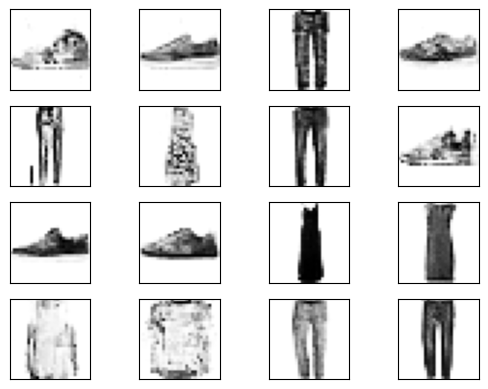

In [ ]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

# if you want improve the result, increase the epochs and learning rates